In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import os

# Predicción de Ingresos de clientes de una Fintech

Este trabajo tiene cómo objetivo predecir, a partir de distintas técnicas de machine learning, el ingreso de una persona con solo su información financiera pública y su declaración de ingresos.

Buscaremos comparar metodologías con respecto al paper "Enhancing User' s Income Estimation with Super-App Alternative Data de Gabriel Suarez et al. (2021)" y "Benchmarking regression algorithms for income prediction modeling. Information Systems, Kibekbaev, A., & Duman, E. (2016)"

Nuestro objetivo es unívoco, al igual que nuestro target, poseemos comprobantes de ingresos digitalizados de los cuales se ha obtenido mediante OCR e imputación manual el número real de ingreso de casi 27mil clientes de una empresa de préstamos online, de ahora en más Fintech [3]. El ingreso puede ser definido cómo la suma de dinero recibido dado en un periodo especifico de tiempo. En nuestro caso seran salarios mensuales.

La información para predecir el ingreso estará basada en dos fuentes de datos, la declaración de la persona, y la información del historial crediticio que obtuvimos del Buró de crédito desarrollado por la empresa TransUnion de México, S.A. SIC [4], qué tiene cómo objetivo "Proporcionar información acerca del Historial Crediticio de las Personas y/o Empresas, de forma clara, eficaz, eficiente y oportuna que aporte para la correcta toma de decisiones."

Haciendo referencia al historial crediticio. "Se define crédito cómo la capacidad provista a un individuo por el sistema financiero donde los clientes reciben un valor monetario... El limite de endeudamiento de un indviduo es decidido por una combinación de factores que por lo general prestadores deciden en función de factores cómo el poder de compra y el ingreso, dado que estos permite determinar cuanto se le puede prestar a un individuo" [2].

Para poner en contexto el caso de estudio, tradicionalmente los grandes jugadores del mercado financiero han sido los bancos. Sin embargo el rapido desarrollo de la economía ha girado hacia los mercados digitales. Los mercados financieros han sido transformados por la tecnología financiera. [5] La innovadora tecnología ha creado distintos modelos de negocio... Estos afectan a diferentes aspectos de la economía, incluyendo servicios de pagos, la industria bancaria tradicional y las regulaciones financieras. [6]


[1] "Enhancing User' s Income Estimation with Super-App Alternative Data de Gabriel Suarez et al. (2021)"

[2] Kibekbaev, A., & Duman, E. (2016). Benchmarking regression algorithms for income prediction modeling. Information Systems, 61, 40–52. doi:10.1016/j.is.2016.05.001

[3] Leong, K. and Sung, A. (2018) ‘FinTech (Financial Technology): What is It and How to Use
Technologies to Create Business Value in Fintech Way?’, International Journal of Innovation,
Management and Technology, vol. 9, no. 2, pp. 74-78. Available at:
http://www.ijimt.org/index.php?m=content&c=index&a=show&catid=93&id=1138.

[4]MC-PF-INTL-TEC-V.13/ V.034 (Manual Técnico INTL - Julio 2020)


[5] Skan, J., Dickerson, J., & Masood, S. 2015. The future of fintech and banking: Digitally disrupted or
reimagined? Tech. rept. Accenture. Available: http://www.accenture.com/us-en/Pages/insight-futurefintech-banking.aspx. Accessed 14 November 2016.

[6] Salmony, M. 2014. Access to accounts: Why banks should embrace an open future. Journal of payments strategy & systems, Vol. 8, Issue 2, 169–170.



En este estudio el instrumento financiero solicitado por los clientes serán los préstamos a través de una aplicación de aprobación online.

> El término préstamo se refiere a un tipo de operación financiera en la cual se presta una suma de dinero a otra parte a cambio de un reembolso futuro del valor o monto principal. En muchos caos, el prestamista también agrega intereses y/o cargos financieros al valor del principal que el prestatario debe pagar... Los préstamos vienen en muchas formas diferentes, incluyendo préstamos garantizados, no grantizados, comerciales y personales

El préstamo conlleva una promesa futura de pago. Por lo tanto también tiene implicito un riesgo de perdidas.

Por lo tanto, el desafío para estas empresas radica en que cada cliente tiene una probabilidad diferente de incumplir con sus obligaciones particulares. Esa probabilidad está determinada por características psicológicas individuales de cada cliente [6] junto con su conocimiento financiero, también por características demográficas y factores situacionales [7]. Cada probabilidad está asignada a un monto individualizado  de pérdida crediticia si el deudor del préstamo incumple con su promesa de pago (Pérdida dado el default) [6,7,8,9].

Por lo tanto, las entidades financieras tienen que responder a dos cuestiones fundamentales para su correcta gestión del riesgo de crédito:

* 1) ¿A qué clientes deben prestarles estas entidades?
* 2) ¿Cuánto dinero les deben prestar?

Para abordar la segunda pregunta, es necesario que las instituciones financieras estimen la capacidad de pago de cada uno de sus clientes. Calcular correctamente la cantidad de dinero que deben prestar a sus clientes permite a las instituciones financieras estimar con precisión su exposición en caso de incumplimiento (Exposición al default ) [1], lo que finalmente lleva a las organizaciones a operar dentro de su pérdida esperada deseada (Perdida esperada) en correspondencia con su aversión por el riesgo.

Desde un punto de vista operativo, en nuestro caso, la decisión de operar respecto al riesgo está dada por una regla impuesta por el negocio. Que tiene en cuenta el ingreso real, los hijos o dependientes a cargos, los pagos a Bureau y el monto de mensualidad seleccionado por el cliente.


$$
  \text{Capacidad de Pago} = \frac{\text{Ingreso real} - 2000*Dependientes - Pagos a Bureau}{Mensualidad} >= 2
$$

> Capacidad de Pago representaría un ratio de liquidez dado por cuantas cuotas o mensualidades de un préstamo puede pagar el ingreso disponible de un cliente-

Se observa que la ecuación de capacidad de pago tiene aclarada la variable "Ingreso Real". Tradicionalmente, las entidades financieras toman como punto de partida la declaración de ingresos de los usuarios. Sin embargo, la disposición de los consumidores a proporcionar esta información es relativamente baja, ya que los ingresos del usuario, al ser parte de la información financiera del usuario, son los datos más sensibles que se deben proporcionar a partir de su información personal identificable [11]. Esto, lleva a las instituciones financieras a intentar estimar los ingresos de los usuarios a partir de la información financiera disponible, y en algunos casos tener que requerirlo a terceras instituciones que recopilan este tipo de datos. Esta estimación es, para algunas organizaciones, el mejor indicador para conocer esta característica relevante del usuario.


[6] Basel Committee on Banking Supervision: The internal ratings-based approach (2001), Consultative Document

[7]  Tokunaga, H.: The use and abuse of consumer credit: Application of psychological theory and research. Journal of
economic psychology 14(2), 285–316 (1993)

[8]  Perry, V.G.: Giving credit where credit is due: the psychology of credit ratings. The Journal of Behavioral Finance 9(1), 15–21 (2008)

[9]  Schuermann, T.: What do we know about loss given default? (2004)

[10] Salvaire, P.: Explaining the predictions of a boosted tree algorithm : application
to credit scoring. Master’s thesis, Universidade Nova de Lisboa (2019)

[11] Phelps, J., Nowak, G., Ferrell, E.: Privacy concerns and consumer willingness to provide personal information. Journal of Public Policy & Marketing 19(1), 27–41 (2000)

In [19]:
path = "../data/"
prospectos = pd.read_csv(path + "prospectos.csv", index_col=0)
prospectos.shape

(12997, 50)

In [24]:
aprobados = pd.read_csv(path + "aprobados.csv", index_col=0)
aprobados.shape

(13828, 51)

In [25]:
df2 = pd.concat([aprobados, prospectos], ignore_index=True, sort=False)
del aprobados
del prospectos
df2.shape


(26825, 52)

Dada la baja voluntad en declarar sus ingresos verdaderos y en el objetivo de no pedir comprobantes, nos encontramos en un dilema.

Las propuestas para abordar el caso son dos:
* 1- El departamento de operaciones preocupado por la conversión sugiere utilizar el Score créditicio >= 680 cómo política para aceptar el ingreso declarado cómo real. La hipótesis es que los clientes con buen score créditicio buscan no perjudicar su historial.
* 2- El departamento de Machine Learning propone un modelo de ingresos que permita minimizar los riesgos sujeto a la cantidad de conversión de la propuesta anterior.


# Dataset


# Diccionario de variables


CLASIFICACIÓN DE PUNTUALIDAD DE PAGO - MOP (Manner of Payment – por sus siglas en inglés)
Contiene el código que indica si la cuenta está al corriente (sin atraso) o tiene atraso en sus pagos.
Los valores que pueden reportarse en este campo están indicados en el Anexo 3- Clasificación de puntualidad de pago-MOP, que se presenta en períodos de 30 días.
Ejemplos: si en Cliente tiene pagos mensuales y 1 pago atrasado MOP= 02. Si tiene pagos semanales: con 1 pago atrasado: MOP= 02; con 2 pagos atrasados: MOP= 02, con 3 pagos MOP= 02, etc.

Clasificación de Puntualidad de Pago – MOP
Las Claves de Clasificación de Puntualidad de Pago – MOP, indica el tiempo transcurrido desde que el Cliente
debió haber cumplido con el compromiso de pago acordado con el Usuario.
La siguiente tabla describe los códigos de Puntualidad de pago o MOP (Manner of Payment).


['fecha de apertura de la cuenta más antigua',
 'fecha de apertura de la cuenta más reciente',
 'fecha de la consulta mas reciente',
 'mensaje de alerta',
 'moneda del credito',
 'nueva direccion en los últimos 60 días',
 'número de cuentas',
 'número de cuentas cerradas',
 'número de cuentas con historial de morosidad',
 'número de cuentas con mop = 00',
 'número de cuentas con mop = 01',
 'número de cuentas con mop = 02',
 'número de cuentas con mop = 03',
 'número de cuentas con mop = 04',
 'número de cuentas con mop = 05',
 'número de cuentas con mop = 06',
 'número de cuentas con mop = 07',
 'número de cuentas con mop = 96',
 'número de cuentas con mop = 97',
 'número de cuentas con mop = 99',
 'número de cuentas con mop = UR',
 'número de cuentas con morosidad actual',
 'número de cuentas de pagos fijos e hipotecarios',
 'número de cuentas en aclaración',
 'número de cuentas en despacho de cobranza o administadora de cartera',
 'número de cuentas revolventes y sin límite pre-establecido',
 'número de solicitudes de consulta',
 'número de solicitudes del informe de buró',
 'número de solicitudes del informe de buró realizadas por despachos de cobranza o administadora de cartera',
 'porcentaje del límite de crédito utilizado para cuentas revolventes y sin límite pre-establecido',
 'total de creditos máximos para cuentas revolventes y sin límite pre-establecido',
 'total de créditos máximos para cuentas de pagos fijos e hipotecarios',
 'total de importe de pago para cuentas de pagos fijos e hipotecarios',
 'total de importe pagado para cuentas revolventes y sin límite pre-establecido',
 'total de límites de crédito para cuentas revolventes y sin límite pre-establecido',
 'total de saldos actuales para cuentas de pagos fijos e hipotecarios',
 'total de saldos actuales para cuentas revolventes y sin límite pre-establecido',
 'total de saldos vencidos para cuentas de pagos fijos e hipotecarios',
 'total de saldos vencidos para cuentas revolventes y sin límite pre-establecido',
 'código de razón 1',
 'código de razón 2',
 'código de razón 3',
 'código del score',
 'nombre del score',
 'valor del score',
 'net_income_verified',
 'ingreso_neto_comprobado',
 'researchable_id']

# Target: ingreso
## Distribución de la muestra vs población mexicana

Según la fuente https://www.gob.mx/stps/prensa/comunicado-conjunto-289406. El ingreso mínimo durante el 2021 fue de 4.000 pesos mexicanos. Por lo tanto en vez de separar la muestra en quantiles, decidimos discretizar según está variable más interpretable

,Cantidad Clientes,Proporcion Muestra,Mexico,% Poblacion Mexico
Ingreso Real,,,,
Hasta 1 salario min,0.0,0.0%,10642543,24.261%
1 hasta 2 salarios,0.0,0.0%,17141160,39.076%
2 hasta 3 salarios,2265.0,8.4%,9818858,22.383%
3 hasta 5 salarios,7726.0,28.8%,4522674,10.31%
+ de 5 salarios,16834.0,62.8%,1741491,3.97%
Total,26825.0,100.0%,43866726,100.0%


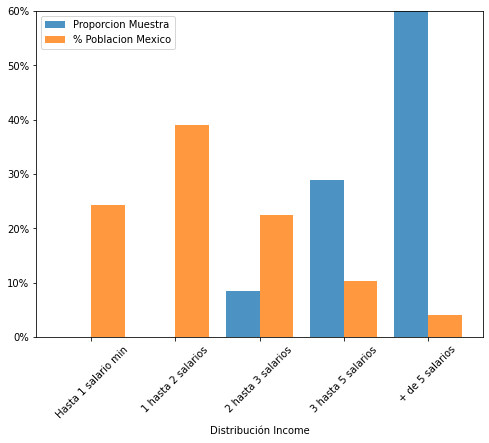

In [26]:
df2["ratio_income_min_w"] = df2["ingreso_real"]/4000

lst = [df2]
for column in lst:
    column.loc[column["ratio_income_min_w"] <= 1,  'salarios_min'] = " Hasta 1 salario min"
    column.loc[(column["ratio_income_min_w"] > 1) & (column["ratio_income_min_w"] <= 2), 'salarios_min'] = "1 hasta 2 salarios"
    column.loc[(column["ratio_income_min_w"] > 2) & (column["ratio_income_min_w"] <= 3), 'salarios_min'] = "2 hasta 3 salarios"
    column.loc[(column["ratio_income_min_w"] > 3) & (column["ratio_income_min_w"] <= 5), 'salarios_min'] = "3 hasta 5 salarios"
    column.loc[column["ratio_income_min_w"] >5, 'salarios_min'] = "+ de 5 salarios"

reorderlist = [" Hasta 1 salario min", "1 hasta 2 salarios","2 hasta 3 salarios","3 hasta 5 salarios", "+ de 5 salarios"]

cantidad = df2.groupby(["salarios_min"]).agg(
    Cantidad =  ('salarios_min', 'count')).reindex(reorderlist)
proporcion = df2.salarios_min.value_counts(normalize=True).reindex(reorderlist).round(3)
inegi_df = pd.merge(cantidad,proporcion, right_index=True, left_index=True)
inegi_df.columns = ["Cantidad Clientes ","Proporcion Muestra"]
inegi_df = inegi_df.reindex(reorderlist)
inegi_df.loc['Total',:]= inegi_df.sum(axis=0)
inegi_df.fillna(0, inplace=True)


inegi_df.index.name = "Ingreso Real"
inegi_df["Mexico"] = [10642543,17141160,9818858,4522674,1741491,43866726]
inegi_df["% Poblacion Mexico"] = [valor/43866726 for valor in inegi_df["Mexico"]]
inegi_plot = inegi_df.copy()
inegi_df["% Poblacion Mexico"] = ((inegi_df["% Poblacion Mexico"]*100).round(3)).astype(str) + '%'
inegi_df["Proporcion Muestra"] = ((inegi_df["Proporcion Muestra"]*100).round(2)).astype(str) + '%'
inegi_plot =inegi_plot.reset_index(level=0)
inegi_plot[0:5].plot(x="Ingreso Real",y=["Proporcion Muestra","% Poblacion Mexico"], kind="bar", width=0.8, alpha=0.8, align='center',figsize=(8,6)).set_ylim([0,0.6])
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in current_values])
plt.xticks(rotation=45)

plt.xlabel('Distribución Income')

inegi_df

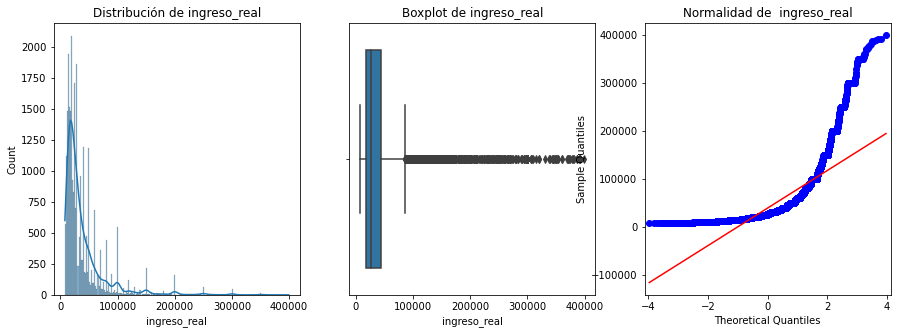

In [27]:
variable = 'ingreso_real'
y = df2[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribución de {variable}")
sns.histplot(data = df2, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot de {variable}")
sns.boxplot(data = df2, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Normalidad de  {variable}")
qqplot(df2[f"{variable}"],line='s',ax=ax[2]);

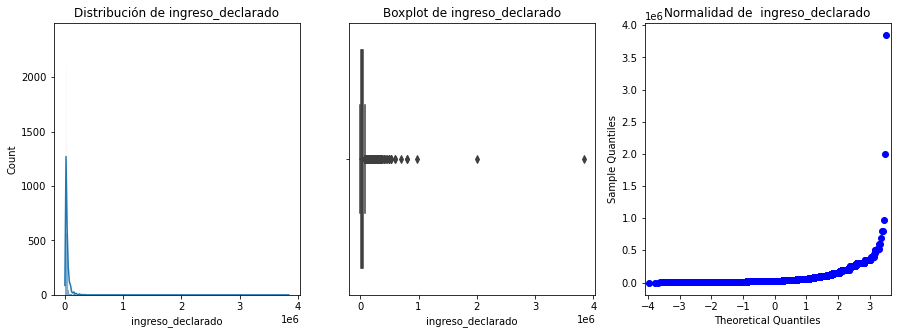

In [28]:
variable = 'ingreso_declarado'
y = df2[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribución de {variable}")
sns.histplot(data = df2, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot de {variable}")
sns.boxplot(data = df2, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Normalidad de  {variable}")
qqplot(df2[f"{variable}"],line='s',ax=ax[2]);

# Declaración de ingresos


$$
Declaran = \frac
{Declared
Income - True
Income}{True
Income}
$$

El gran problema representa 2843 clientes y representa el 10.60% de la población que conocemos el ingreso real 



,Cantidad Clientes,Proporcion
Declaran,,
Más del 100%,718,3.0%
entre 51% y 99% más,1062,4.0%
entre 31% y 50% más,1063,4.0%
entre 1% y 30% más,3410,13.0%
Lo Mismo,17162,64.0%
Menos,3405,13.0%
Total,26820,100.0%


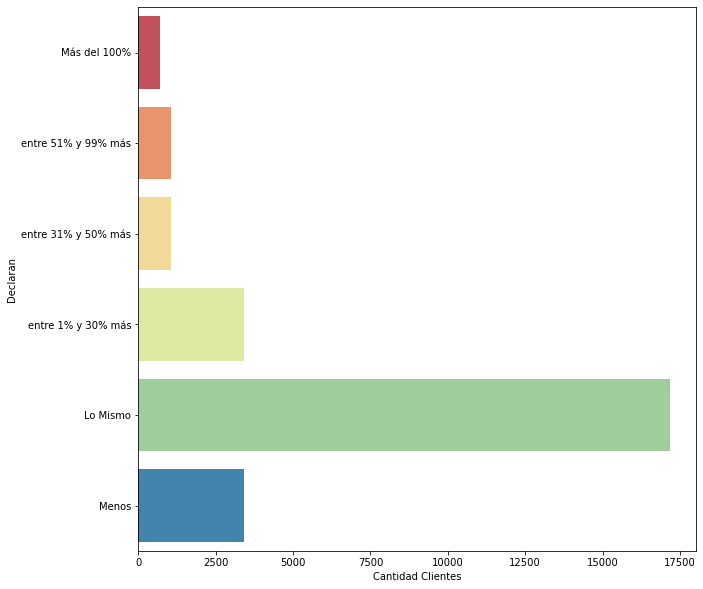

In [29]:

df2["diff_per"] = (df2["ingreso_declarado"] - df2["ingreso_real"]) / df2["ingreso_real"]
#dataframe.loc[(condicion),columnas en particular]
df2.loc[df2["diff_per"] == 0, 'Declaran'] = "Lo Mismo"
df2.loc[(df2["diff_per"] < 0), 'Declaran'] = "Menos"
df2.loc[(df2["diff_per"] > 0) & (df2["diff_per"] <= 0.3), 'Declaran'] = "entre 1% y 30% más"
df2.loc[(df2["diff_per"] > 0.3) & (df2["diff_per"] <= 0.5), 'Declaran'] = "entre 31% y 50% más"
df2.loc[(df2["diff_per"] > 0.5) & (df2["diff_per"] < 1), 'Declaran'] = "entre 51% y 99% más"
df2.loc[(df2["diff_per"] >= 1), 'Declaran'] = "Más del 100%"
reorderlist = ["Más del 100%", "entre 51% y 99% más", "entre 31% y 50% más", "entre 1% y 30% más", "Lo Mismo", "Menos"]

declararon = pd.merge(df2.Declaran.value_counts(), df2.Declaran.value_counts(normalize=True), right_index=True,
                      left_index=True)
declararon.columns = ["Cantidad Clientes", "Proporcion"]
declararon = declararon.reindex(reorderlist)
declararon.index.name = "Declaran"

plt.figure(figsize=(10, 10))
paleta = ["#d53e4f", "#fc8d59", "#fee08b", "#e6f598", "#99d594", "#3288bd"]
sns.barplot(x="Cantidad Clientes", y=declararon.index, data=declararon, palette=paleta)
plt.savefig("cantidad.png", bbox_inches='tight')
declararon.loc['Total', :] = declararon.sum(axis=0)

per_problema = declararon[0:3]["Proporcion"].sum(axis=0)

declararon["Proporcion"] = (declararon["Proporcion"].round(2) * 100).astype(str) + '%'
declararon["Cantidad Clientes"] = declararon["Cantidad Clientes"].astype(int)
total_problema = declararon[0:3]["Cantidad Clientes"].sum(axis=0)

print(  f"El gran problema representa {total_problema} clientes y representa el {(per_problema * 100):.2f}% de la población que conocemos el ingreso real \n")
declararon

# Exploracion de variables
## Correlaciones
## Separar por tipo cuenta,ingreso,etc
## Histplots
## pairplots

# Mentira vs Verdad

# Definición de Capacidad de Pago
## Hipotesis del negocio

In [ ]:
cantidad = df2.groupby(["salarios_min"]).agg(
    Cantidad =  ('salarios_min', 'count')).reindex(reorderlist)
proporcion = df2.salarios_min.value_counts(normalize=True).reindex(reorderlist)

# Capacidad de Pago

## Matrices de confusion.


# Ratios
# Regresion
# Ligthgbm